# Generalized Linear Models

### Environment Setup
**⚠️Note: If running on a new environment, run this cell once and then restart the kernel⚠️**

In [3]:
try:
    from dandi_utils import dandi_download_open
except:
    !git clone https://github.com/AllenInstitute/openscope_databook.git
    %cd openscope_databook
    %pip install -e .

c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [4]:
import os
import numpy as np

import matplotlib.pyplot as plt
import statsmodels.api as sm

from numpy.linalg import inv
from scipy import interpolate

%matplotlib inline

### Downloading Files

In [5]:
dandiset_id = "000021"
dandi_filepath = "sub-717038285/sub-717038285_ses-732592105.nwb"
# dandiset_id = "000563"
# dandi_filepath = "sub-688546/sub-688546_ses-1295360519.nwb"
download_loc = "."
dandi_api_key = os.environ["DANDI_API_KEY"]

In [6]:
io = dandi_download_open(dandiset_id, dandi_filepath, download_loc, dandi_api_key=dandi_api_key)
nwb = io.read()

A newer version (0.58.1) of dandi/dandi-cli is available. You are using 0.55.1


PATH                            SIZE   DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-717038285_ses-732592105.nwb 2.9 GB 2.9 GB           100%    ok    done                   
Summary:                        2.9 GB 2.9 GB                         1 done                 
                                       100.00%                                               
Downloaded file to ./sub-717038285_ses-732592105.nwb
Opening file


c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


### Selecting Neurons

In [7]:
spike_times = nwb.units[0].spike_times.item()

### Making Stim Trace

In [13]:
nwb.intervals.keys()

dict_keys(['drifting_gratings_presentations', 'flashes_presentations', 'gabors_presentations', 'invalid_times', 'natural_movie_one_presentations', 'natural_movie_three_presentations', 'natural_scenes_presentations', 'spontaneous_presentations', 'static_gratings_presentations'])

In [14]:
flashes_table = nwb.intervals["flashes_presentations"]
# flashes_table = nwb.intervals["RepeatFFF_presentations"]
flashes_table[:10]

,start_time,stop_time,stimulus_name,stimulus_block,color,mask,opacity,phase,size,units,stimulus_index,orientation,spatial_frequency,contrast,tags,timeseries
id,,,,,,,,,,,,,,,,
0,1282.632614,1282.882832,flashes,1.0,-1.0,None,1.0,"[0.0, 0.0]","[300.0, 300.0]",deg,1.0,0.0,"[0.0, 0.0]",0.8,[stimulus_time_interval],"[(3647, 1, timestamps pynwb.base.TimeSeries at..."
1,1284.634334,1284.884540,flashes,1.0,1.0,None,1.0,"[0.0, 0.0]","[300.0, 300.0]",deg,1.0,0.0,"[0.0, 0.0]",0.8,[stimulus_time_interval],"[(3648, 1, timestamps pynwb.base.TimeSeries at..."
2,1286.636014,1286.886217,flashes,1.0,1.0,None,1.0,"[0.0, 0.0]","[300.0, 300.0]",deg,1.0,0.0,"[0.0, 0.0]",0.8,[stimulus_time_interval],"[(3649, 1, timestamps pynwb.base.TimeSeries at..."
3,1288.637634,1288.887855,flashes,1.0,-1.0,None,1.0,"[0.0, 0.0]","[300.0, 300.0]",deg,1.0,0.0,"[0.0, 0.0]",0.8,[stimulus_time_interval],"[(3650, 1, timestamps pynwb.base.TimeSeries at..."
4,1290.639354,1290.889562,flashes,1.0,1.0,None,1.0,"[0.0, 0.0]","[300.0, 300.0]",deg,1.0,0.0,"[0.0, 0.0]",0.8,[stimulus_time_interval],"[(3651, 1, timestamps pynwb.base.TimeSeries at..."
5,1292.641034,1292.891240,flashes,1.0,1.0,None,1.0,"[0.0, 0.0]","[300.0, 300.0]",deg,1.0,0.0,"[0.0, 0.0]",0.8,[stimulus_time_interval],"[(3652, 1, timestamps pynwb.base.TimeSeries at..."
6,1294.642714,1294.892917,flashes,1.0,1.0,None,1.0,"[0.0, 0.0]","[300.0, 300.0]",deg,1.0,0.0,"[0.0, 0.0]",0.8,[stimulus_time_interval],"[(3653, 1, timestamps pynwb.base.TimeSeries at..."
7,1296.644364,1296.894572,flashes,1.0,-1.0,None,1.0,"[0.0, 0.0]","[300.0, 300.0]",deg,1.0,0.0,"[0.0, 0.0]",0.8,[stimulus_time_interval],"[(3654, 1, timestamps pynwb.base.TimeSeries at..."
8,1298.646074,1298.896272,flashes,1.0,1.0,None,1.0,"[0.0, 0.0]","[300.0, 300.0]",deg,1.0,0.0,"[0.0, 0.0]",0.8,[stimulus_time_interval],"[(3655, 1, timestamps pynwb.base.TimeSeries at..."


In [15]:
len(set(flashes_table.color))

2

### Getting Running Times

In [16]:
running_data = nwb.processing["running"]["running_speed"].data
running_timestamps = nwb.processing["running"]["running_speed"].timestamps

### Interpolating Times

In [17]:
first_run_time = running_timestamps[0]
last_run_time = running_timestamps[-1]
first_stim_time = flashes_table.start_time[0]
last_stim_time = flashes_table.stop_time[-1]
first_time = max(first_stim_time, first_run_time)
last_time = min(last_stim_time, last_run_time)

run_start_idx, run_end_idx = np.searchsorted(running_timestamps, [first_time, last_time])
stim_start_idx, stim_end_idx = np.searchsorted(flashes_table.start_time, [first_time, last_time])

running_data_slice = running_data[run_start_idx:run_end_idx]
running_timestamps_slice = running_timestamps[run_start_idx:run_end_idx]

print("first time:", first_time, "last time:", last_time)

first time: 1282.6326142945445 last time: 1581.1321471083802


In [18]:
bin_res = np.mean(np.diff(flashes_table.start_time)) / 3
interp_hz = 1/bin_res
interp_hz

1.4987460323884054

In [19]:
colors = flashes_table.color[stim_start_idx:stim_end_idx]
flash_frames = np.zeros(len(colors))
for i, color in enumerate(colors):
    flash_frames[i] = 1.0 if color == "1.0" else 0

# colors = flashes_table.color[stim_start_idx:stim_end_idx]
# flash_frames = np.zeros(len(colors))
# for i, color in enumerate(colors):
#     flash_frames[i] = float(color)

In [20]:
time_axis = np.arange(first_time, last_time, step=(1/interp_hz))
f = interpolate.interp1d(flashes_table.start_time, flash_frames, axis=0, kind="nearest", fill_value="extrapolate")
interp_flashes = f(time_axis)

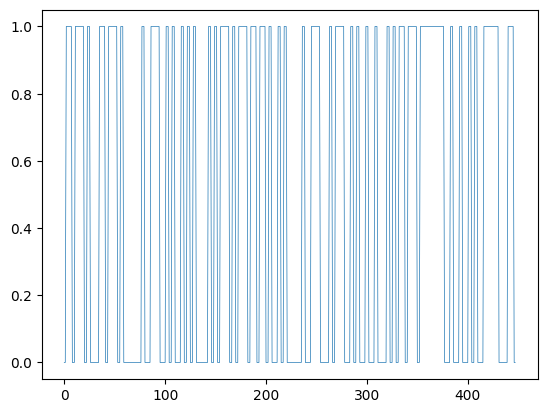

In [42]:
plt.plot(interp_flashes, lw=0.5)

In [22]:
# generate regularly-space x values and interpolate along it
time_axis = np.arange(first_time, last_time, step=(1/interp_hz))
f = interpolate.interp1d(running_timestamps_slice, running_data_slice, axis=0, kind="nearest", fill_value="extrapolate")
interp_running = f(time_axis)

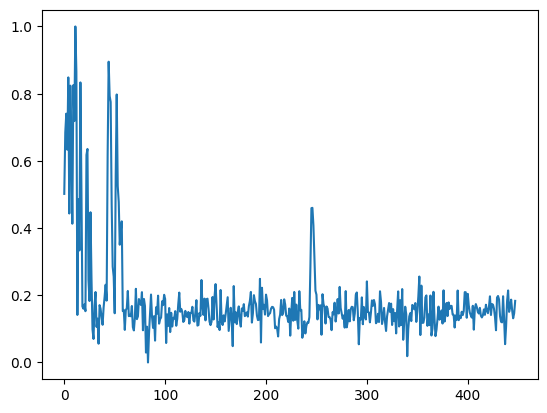

In [23]:
# plt.plot(interp_running)
norm_running = (interp_running-np.min(interp_running)) / (np.max(interp_running)-np.min(interp_running))
plt.plot(norm_running)

In [24]:
print(len(interp_flashes))
print(len(norm_running))

448
448


### Combine Stims

In [25]:
# coefficient to add running to stimulus
mod_coef = 0.25

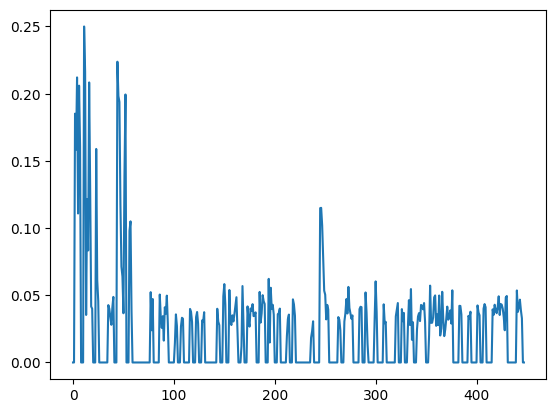

In [26]:
exog = interp_flashes * (norm_running * mod_coef)
plt.plot(exog)

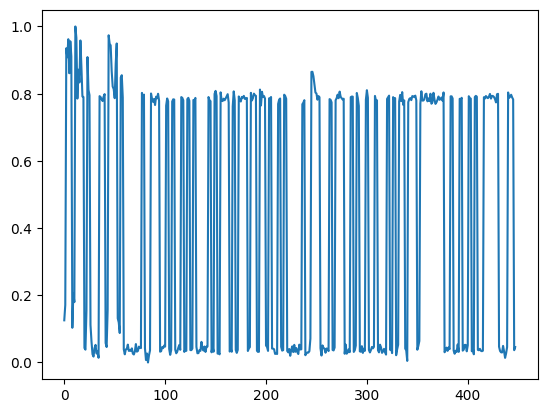

In [44]:
exog = 0.75*interp_flashes + 0.25*norm_running
plt.plot(exog)

### Building Design Matrix

In [45]:
ntfilt = 50

In [46]:
def get_design_mat(ntfilt, stim, num_time_bins):
    padded_stim = np.hstack((np.zeros((ntfilt-1)), stim)) # pad early bins of stimulus with zero
    design_mat = np.zeros((num_time_bins,ntfilt))
    for j in np.arange(num_time_bins):
        design_mat[j] = padded_stim[j:j+ntfilt] # grab last 'nkt' bins of stmiulus and insert into this row
    return design_mat

In [47]:
num_time_bins = len(exog)
design_mat = get_design_mat(ntfilt, exog, num_time_bins)

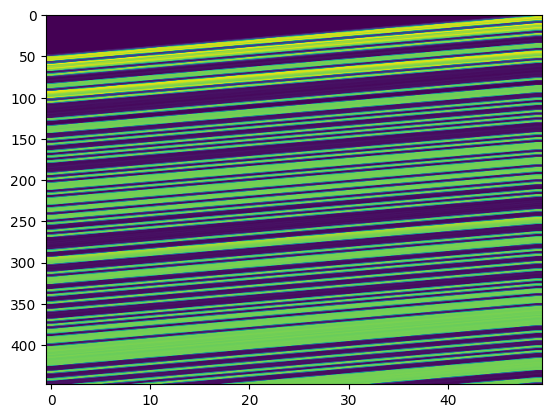

In [48]:
plt.imshow(design_mat, aspect="auto")

### Getting STA

In [49]:
def STA(design_mat, spikes_binned, num_spikes):
    return (design_mat.T @ spikes_binned) / num_spikes

def WSTA(design_mat, spikes_binned, num_spikes):
    sta = STA(design_mat, spikes_binned, num_spikes)
    return inv(design_mat.T @ design_mat) @ sta * num_spikes

In [50]:
num_spikes = len(spike_times)
spikes_bin_centers = np.arange(num_time_bins+1) * interp_hz # centers of bins for applying to spike train
spikes_binned,_ = np.histogram(spike_times, spikes_bin_centers)

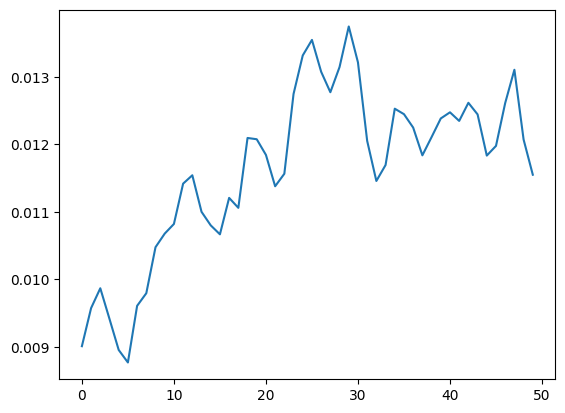

In [51]:
plt.plot(STA(design_mat, spikes_binned, num_spikes))

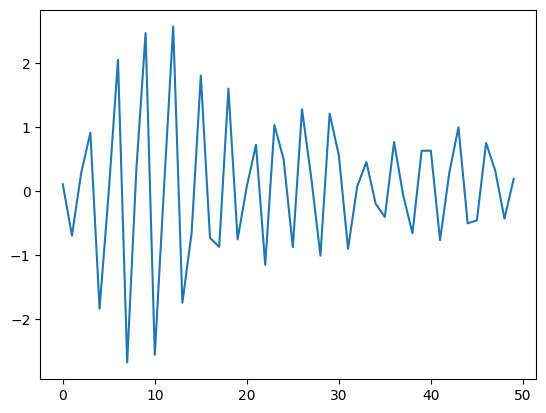

In [52]:
plt.plot(WSTA(design_mat, spikes_binned, num_spikes))

### Running MLE

In [53]:
def MLE(design_mat, spikes_binned):
    design_mat_offset = np.hstack((np.ones((design_mat.shape[0],1)), design_mat)) # just add a column of ones

    glm_poisson_exp = sm.GLM(endog=spikes_binned, exog=design_mat_offset,
                            family=sm.families.Poisson())

    pGLM_results = glm_poisson_exp.fit(max_iter=100, tol=1e-6, tol_criterion='params')

    # pGLM_const = glm_poisson_exp[-1].fit_['beta0'] # constant ("dc term)")
    pGLM_const = pGLM_results.params[0]
    pGLM_filt = pGLM_results.params[1:] # stimulus filter

    return pGLM_filt, pGLM_const

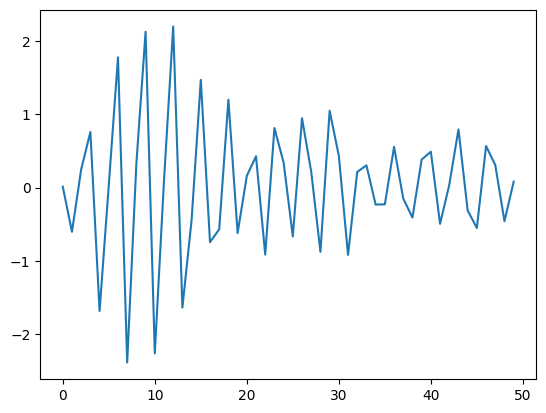

In [54]:
filt, const = MLE(design_mat, spikes_binned)
plt.plot(filt)

### running on many cells

In [55]:
def get_filter(spike_times, method="poisson"):
    these_spikes_bin_centers = np.arange(num_time_bins+1) * interp_hz # centers of bins for applying to spike train
    these_spikes_binned,_ = np.histogram(spike_times, these_spikes_bin_centers)

    print(len(spike_times))

    if method == "poisson":
        return MLE(design_mat, these_spikes_binned)
    elif method == "sta":
        return STA(design_mat, these_spikes_binned, num_spikes), 0
    elif method == "wsta":
        return WSTA(design_mat, these_spikes_binned, num_spikes), 0

In [56]:
filters = []
for i in range(100):
    try:
        if nwb.units[i].quality.item() == "good":
            print(i)
            filter, const = get_filter(nwb.units[i].spike_times.item())
            filters.append(filter)
    except:
        continue

0
19167
1
54029
2
18905
3
44339
4
20540
5
58866
6
158831
7
83


c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1257: P

8
19246
9
4679
10
48611
11
152609
12
56734
13
558
14
3466
15
13
16
45937
17
236
18
2940
19
18756
20
17481
21
46140
22
1912
23
2308
24
40692
25
33078
26
10227
27
39899
28
59805
29
137977
30
56470
31
995
32
15223
33
124426
34
134785
35
353
36
6146
37
15482
38
78548
39
97823
40
33855
42
83601
43
17813
44
35219
45
64737
46
38922
47
2230
48
190
49
48800
50
39773
51
368
52
434
53
1078
54
20176
55
13440
56
22006
57
3188
58
33034
59
9015
60
8711
61
9393
62
66418
63
29754
64
31124
65
35718
66
27698
67
210
68
65500
69
33432
70
95365
71
8549
72
5897
73
76099
74
66870
75
14873
76
102323
77
113259
78
31123
79
60666
80
127896
81
15510
82
16362
83
1954
84
6925
85
30378
86
16047
87
3417
88
1905
89
18204
90
12515
91
20467
92
23954
93
62574
94
18903
95
12662
96
58142
97
43127
98
2482
99
19586


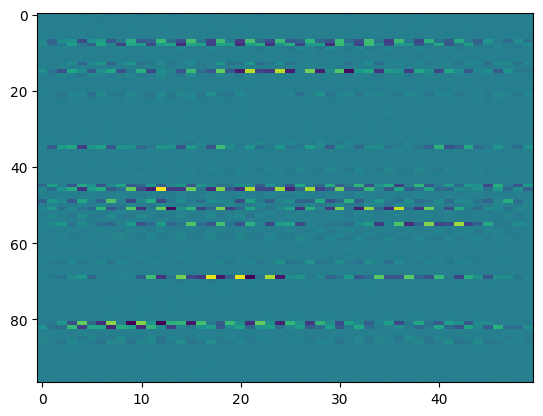

In [57]:
plt.imshow(np.array(filters), aspect="auto")

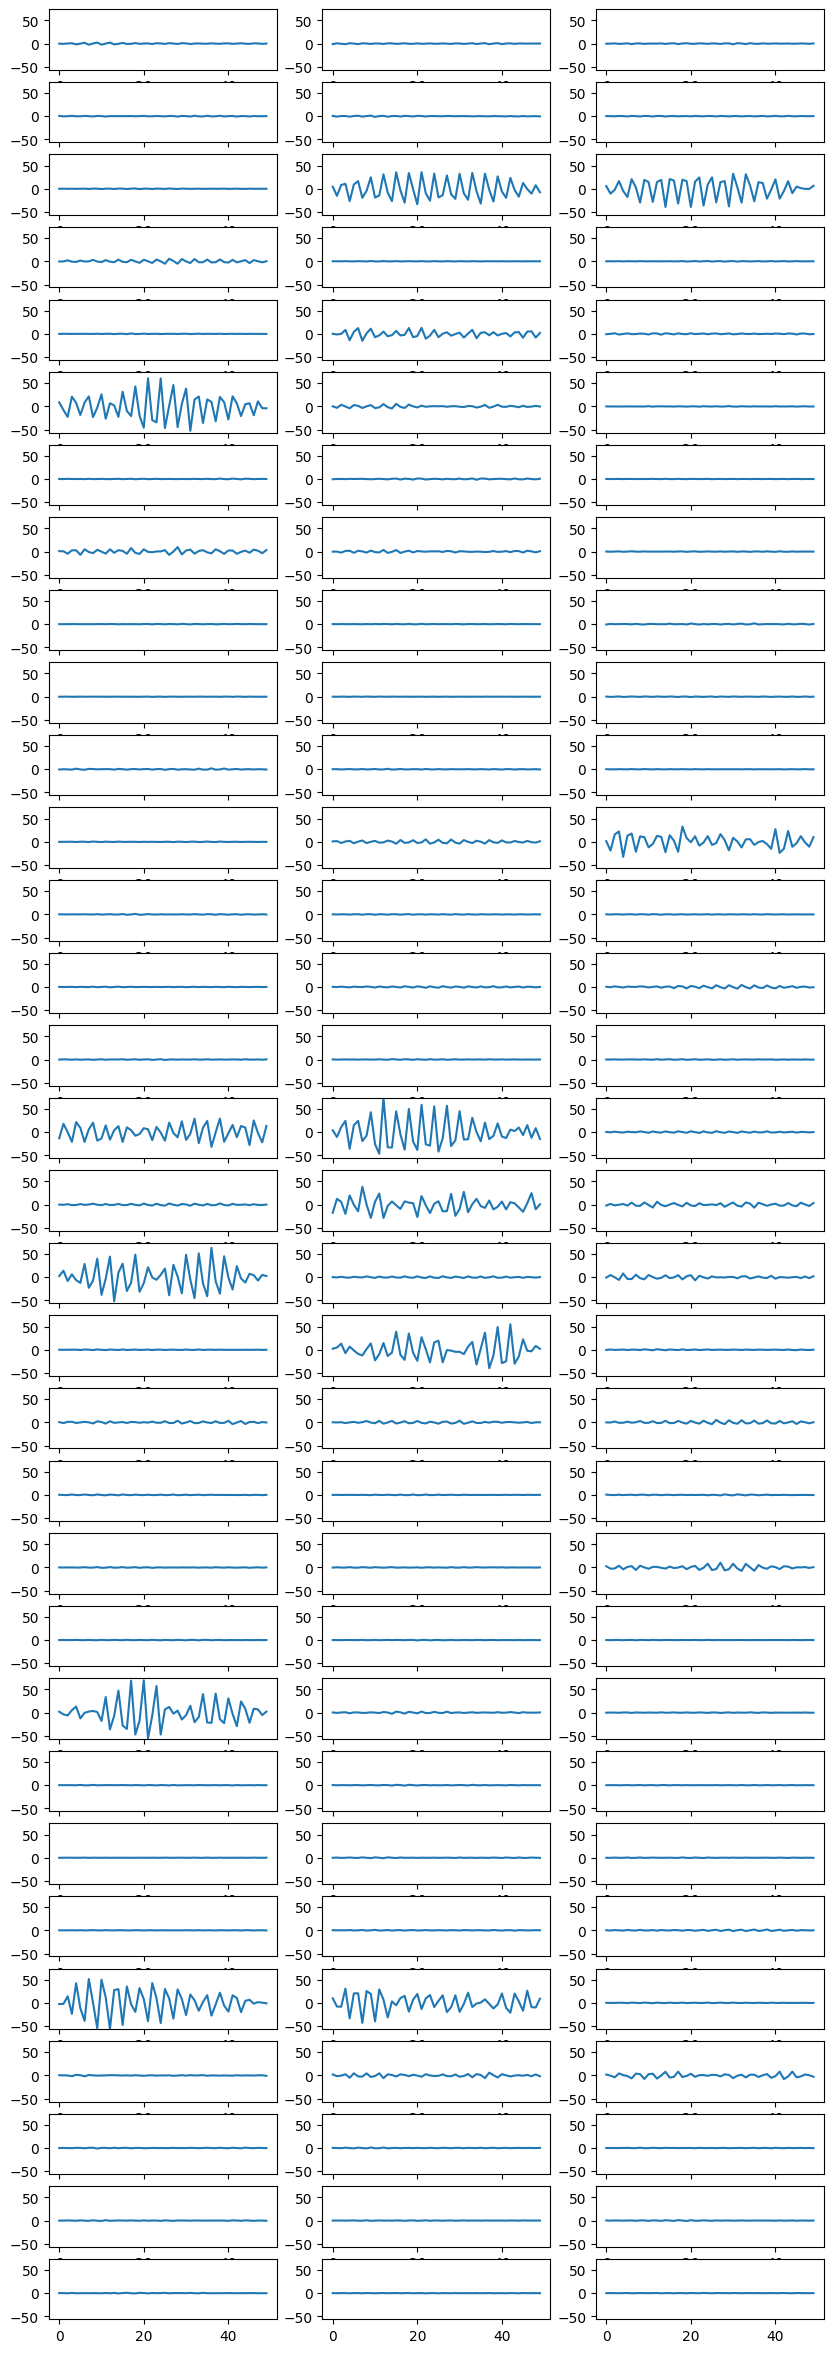

In [58]:
ymax, ymin = 0, 0
for i in range(len(filters)):
    filter = filters[i]
    if max(filter) > ymax:
        ymax = max(filter)
    if min(filter) < ymin:
        ymin = min(filter)

fig, axes = plt.subplots(len(filters)//3, 3, figsize=(10,30))
for i in range(len(axes.flatten())):
    filter = filters[i]
    row = i // 3
    col = i % 3
    axes[row][col].plot(filter)
    axes[row][col].set_ylim([ymin, ymax])

### Attempting usage